Death Valley National Park sits in eastern California in the northern Mojave Desert, bordering the Great Basin Desert and is famous for being the hottest and driest place in North America. According to the National Parks Service, the summer temperatures often top 120°F (49°C) in the shade with overnight lows dipping into the 90s°F (mid-30s°C). And, its landscape includes- salt flats, dunes, badlands, canyons, and spring-fed oases, which support hardy, desert-adapted wildlife like bighorn sheep, kit foxes, and a few tiny, endemic pupfish. This analysis looks at changes in annual average temperature at Death Valley from 1990 to 2024. I chose the site because its record heat and extreme aridity makes it a clear, compelling place to see how warming trends are playing out in a highly stressed desert environment.

In [1]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import Packages
import pandas as pd
import holoviews as hv
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

Data Description

The data comes from the Global Historical Climatology Network–Daily (GHCN-Daily, “GHCNd”), a global archive of land surface observations from 90,000+ stations, incorporating World Meteorological Organization, U.S. Cooperative, and CoCoRaHS networks. For Death Valley National Park I use station USC00042319 (Furnace Creek, CA), retrieved via NOAA NCEI’s Daily Summaries API. I request the TOBS variable (temperature at the daily observation time) in °C for 1990-01-01 to 2024-12-31. Raw GHCNd temperatures are stored in tenths of °C; the API’s units=metric parameter returns values in °C. After removing missing values, we compute calendar-year means for each full year in 1990–2024 for trend analysis.

Citations:

Menne, M. J., I. Durre, R. S. Vose, B. E. Gleason, & T. G. Houston (2012). An Overview of the Global Historical Climatology Network-Daily Database. Journal of Atmospheric and Oceanic Technology, 29, 897–910. https://doi.org/10.1175/JTECH-D-11-00103.1

NOAA National Centers for Environmental Information (NCEI). GHCN-Daily: Global Historical Climatology Network—Daily, Version 3. https://doi.org/10.7289/V5D21VHZ. Accessed 2025-10-01.

NOAA NCEI. Daily Summaries API, station USC00042319 (Death Valley/Furnace Creek, CA), TOBS, 1990–2024. Accessed 2025-10-01.


In [2]:
dv_url = (
    "https://www.ncei.noaa.gov/access/services/data/v1?"
    "dataset=daily-summaries&"
    "stations=USC00042319&"
    "dataTypes=TOBS&"
    "startDate=1990-01-01&"
    "endDate=2024-12-31&"
    "units=metric" # this here will get me the data in celsius
)

dv_url



'https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USC00042319&dataTypes=TOBS&startDate=1990-01-01&endDate=2024-12-31&units=metric'

Analysis

In the next code chunks, I parse the daily data, remove missing values etc.  I then computed annual mean temperature from daily TOBS and fit an ordinary least squares (OLS) regression of annual mean temperature on Year to estimate a linear trend (°C per year), reporting the slope (also expressed per decade). Further, I visualized the results with a scatter plot of annual means and an overlaid fitted line, and I inspected residuals to check basic model assumptions (linearity and homoscedasticity).

In [3]:


# Download the death valley climate data using the url
dv_df = pd.read_csv(
    dv_url,
    index_col='DATE',
    parse_dates=True,
    na_values=['NaN']
)

# Check if the data was downloaded
dv_df.head()

,STATION,TOBS
DATE,,
1990-01-01,USC00042319,5.0
1990-01-02,USC00042319,10.0
1990-01-03,USC00042319,10.6
1990-01-04,USC00042319,0.6
1990-01-05,USC00042319,0.6


In [4]:
# Save the climate data
dv_df.to_csv('death_valley_temp')

In [5]:

# selecting the column for temperature at time of observation and ...
# ....reassign to the dataframe.
dv_df = dv_df[['TOBS']]
dv_df

,TOBS
DATE,
1990-01-01,5.0
1990-01-02,10.0
1990-01-03,10.6
1990-01-04,0.6
1990-01-05,0.6
...,...
2024-12-27,NaN
2024-12-28,NaN
2024-12-29,NaN


In [6]:
# Resample data to obtain the mean annual temperature.
ann_dv_df = dv_df.resample('YS').mean()
ann_dv_df.head()

,TOBS
DATE,
1990-01-01,20.107713
1991-01-01,19.918539
1992-01-01,21.048087
1993-01-01,20.397802
1994-01-01,21.449863


In [13]:
# Plot the annual data 
ann_dv_df_plot = ann_dv_df.hvplot(y='TOBS',
    title=' Mean Annual Temperature (C) of Death Valley National Park, USA',
    xlabel='Year',
    ylabel='Mean Annual Temperature (celsius )',
    )

ann_dv_df_plot

:Curve   [DATE]   (TOBS)

In [8]:
# Fitting an OLS Linear Regression to the data

# Drop NaN values
ann_dv_df_new = ann_dv_df.dropna()

# Reshape 'Year' column to be a 2D array for scikit-learn
X = ann_dv_df_new.index.values.reshape(-1,1)
Y = ann_dv_df_new['TOBS'].values

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, Y)

# get the slope and intercept
slope = model.coef_[0]
intercept = model.intercept_


#print the results
print(f"Slope: {slope}")
print(f"Intercept:{intercept}")

Slope: 3.791109956725465e-18
Intercept:17.779294967430808


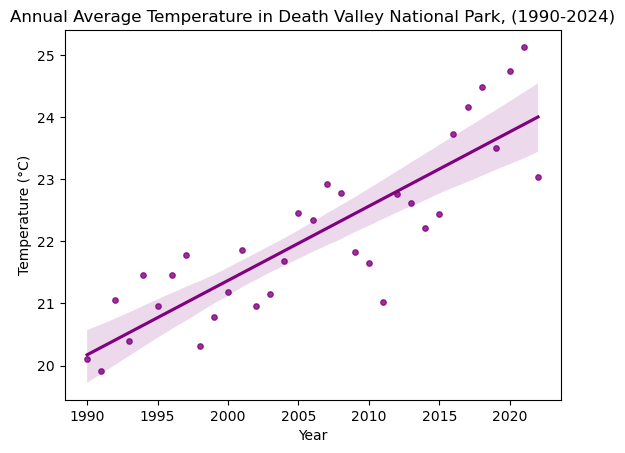

In [9]:
# Plot annual average temperature with a trend line
dvnp_plot = sns.regplot(
    x = ann_dv_df_new.index.year, 
    y = ann_dv_df_new.TOBS, 
    scatter_kws={"s": 15, "color": "purple"},   # points
    line_kws={"color": "purple"}                # trend line
)

# Set plot labels
dvnp_plot.set(
   title="Annual Average Temperature in Death Valley National Park, (1990-2024)",
    xlabel="Year",
    ylabel="Temperature (°C)"
)
# Display the plot without extra text
plt.show()